#install  libs

In [ ]:
!pip install -r https://raw.githubusercontent.com/huggingface/deep-rl-class/main/notebooks/unit2/requirements-unit2.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.1/132.1 kB 11.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 682.2/682.2 kB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 33.8 MB/s eta 0:00:00
  Created wheel for pickle5: filename=pickle5-0.0.11-cp310-cp310-linux_x86_64.whl size=255320 sha256=6c36d3af410dc4240423fec5a2527c726946a993d74f51de48bb75df474f01df
  Stored in directory: /root/.cache/pip/wheels/7d/14/ef/4aab19d27fa8e58772be5c71c16add0426acf9e1f64353235c
Successfully built pickle5
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 6.0.1
    Uninstalling PyYAML-6.0.1:
      Successfully uninstalled PyYAML-6.0.1


In [ ]:
!sudo apt-get -q update
!sudo apt-get install -q -y python3-opengl
!apt install ffmpeg xvfb
!pip3 install -q  pyvirtualdisplay

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [830 kB]
Get:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [2,069 kB]
Get:13 http://archive.

In [ ]:
import os
os.kill(os.getpid(), 9)

In [1]:
from pyvirtualdisplay import Display
virtual_display = Display(visible=0, size=(1400, 900))
virtual_display.start()
import numpy as np
import gymnasium as gym
import random
import imageio
import os
import tqdm
import pickle5 as pickle
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from collections import defaultdict

# Task 1

### FrozenLake-v1

In [2]:
env = gym.make("FrozenLake-v1", map_name="4x4", is_slippery=False, render_mode="rgb_array")

In [3]:
state_space = env.observation_space.n
action_space = env.action_space.n
print("state_space:", state_space)
print("action_space:", action_space)

state_space: 16
action_space: 4


The action shape is (1,) in the range {0, 3} indicating which direction to move the player.

0: Move left

1: Move down

2: Move right

3: Move up

In [4]:
i2action = {
    0:'left',
    1:'down',
    2:'right',
    3:'up'
}

In [5]:
def initialize_q_table(state_space, action_space):
  Qtable = np.zeros((state_space, action_space))
  return Qtable

def greedy_policy(Qtable, state):
  action = np.argmax(Qtable[state][:])
  return action

def epsilon_greedy_policy(Qtable, state, epsilon, ):
  random_num = geterator.random()
  if random_num > epsilon:
    action = greedy_policy(Qtable, state)
  else:
    action = env.action_space.sample()

  return action

Qtable_frozenlake = initialize_q_table(state_space, action_space)
geterator = np.random.default_rng()

In [6]:
n_training_episodes = 20_000
learning_rate = 0.2
n_eval_episodes = 1000
max_steps = 50
gamma = 0.9
eval_seed = []
max_epsilon = 1.0
min_epsilon = 0
decay_rate = 0.0005

In [7]:
class LinearDecay:
    def __init__(self,  min_epsilon, max_epsilon, total_steps):
        if min_epsilon > max_epsilon:
            raise ValueError("Error: min_epsilon > max_epsilon!")
        self.min_epsilon = min_epsilon
        self.max_epsilon = max_epsilon
        self.total_steps = total_steps
        self.iter = 0

    def __call__(self):
        self.iter += 1
        if self.iter == 0:
            return self.max_epsilon
        if self.iter > self.total_steps:
            return self.min_epsilon
        return self.max_epsilon - (self.max_epsilon - self.min_epsilon) / self.total_steps * self.iter

In [8]:
class ConstantDecay:
    def __init__(self,  min_epsilon, max_epsilon, decay_rate):
        if min_epsilon > max_epsilon:
            raise ValueError("Error: min_epsilon > max_epsilon!")
        self.min_epsilon = min_epsilon
        self.max_epsilon = max_epsilon
        self.decay_rate = decay_rate
        self.current_epsilon = max_epsilon
        self.iter = 0

    def __call__(self):
        self.iter += 1
        if self.current_epsilon < self.min_epsilon:
            return self.min_epsilon
        res_value = self.current_epsilon
        self.current_epsilon -= self.decay_rate
        return res_value

In [9]:
def train_frozenlake(learning_rate, n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps, Qtable):
    if decay_rate is None:
        reduce_epsilon = LinearDecay(min_epsilon, max_epsilon, int(n_training_episodes * 0.9))
    else:
        reduce_epsilon = ConstantDecay(min_epsilon, max_epsilon, decay_rate)

    for episode in tqdm(range(n_training_episodes)):
        epsilon = reduce_epsilon()
        if abs(epsilon) < 0.000001:
            learning_rate = 0.0001
        state, info = env.reset()
        step = 0
        terminated = False
        truncated = False

        while not terminated and not truncated:
            action = epsilon_greedy_policy(Qtable, state, epsilon)

            new_state, reward, terminated, truncated, info = env.step(action)

            Qtable[state][action] = Qtable[state][action] + learning_rate * (reward + gamma * np.max(Qtable[new_state]) - Qtable[state][action])

            if truncated:
                Qtable[state][action] = Qtable[state][action] + learning_rate * (-0.01 + gamma * np.max(Qtable[new_state]) - Qtable[state][action])

                break

            state = new_state
    return Qtable

In [10]:
Qtable_frozenlake = train_frozenlake(learning_rate, n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps, Qtable_frozenlake)

  0%|          | 0/20000 [00:00<?, ?it/s]

In [11]:
Qtable_frozenlake

array([[0.531441  , 0.59049   , 0.59049   , 0.531441  ],
       [0.531441  , 0.        , 0.6561    , 0.59049   ],
       [0.59049   , 0.729     , 0.59049   , 0.6561    ],
       [0.6561    , 0.        , 0.58937799, 0.5894722 ],
       [0.59007602, 0.6561    , 0.        , 0.53143888],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.81      , 0.        , 0.6561    ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.65489816, 0.        , 0.729     , 0.58251605],
       [0.65531099, 0.81      , 0.8097472 , 0.        ],
       [0.729     , 0.9       , 0.        , 0.729     ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.80981328, 0.9       , 0.72766166],
       [0.80999998, 0.9       , 1.        , 0.81      ],
       [0.        , 0.        , 0.        , 0.        ]])

In [13]:
def evaluate_agent(env, max_steps, n_eval_episodes, Q, seed):
    episode_rewards = []
    for episode in tqdm(range(n_eval_episodes)):
        if seed:
            state, info = env.reset(seed=seed[episode])
        else:
            state, info = env.reset()
        step = 0

        truncated = False
        terminated = False
        total_rewards_ep = 0

        for step in range(max_steps):
            action = greedy_policy(Q, state)
            new_state, reward, terminated, truncated, info = env.step(action)
            total_rewards_ep += reward

            if terminated or truncated:
                break
            state = new_state
        episode_rewards.append(total_rewards_ep)
    mean_reward = np.mean(episode_rewards)
    std_reward = np.std(episode_rewards)
    return mean_reward, std_reward

In [14]:
# Evaluate our Agent
mean_reward, std_reward = evaluate_agent(env, max_steps, n_eval_episodes, Qtable_frozenlake, eval_seed)
print(f"Mean_reward={mean_reward:.2f} +/- {std_reward:.2f}")

  0%|          | 0/1000 [00:00<?, ?it/s]

Mean_reward=1.00 +/- 0.00


### Blackjack-v1

In [15]:
env = gym.make("Blackjack-v1",sab=True, render_mode="rgb_array")

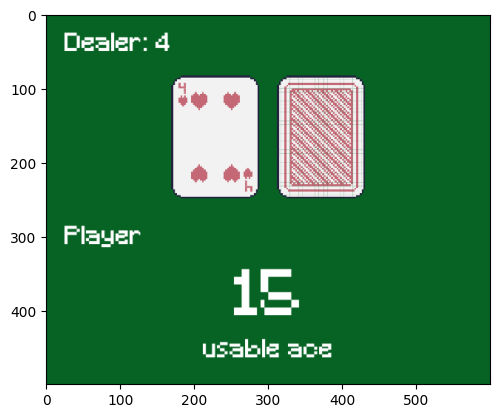

In [16]:
env.reset()
plt.imshow(env.render())

initial observation code: ((17, 10, 0), {})
action_space: 2


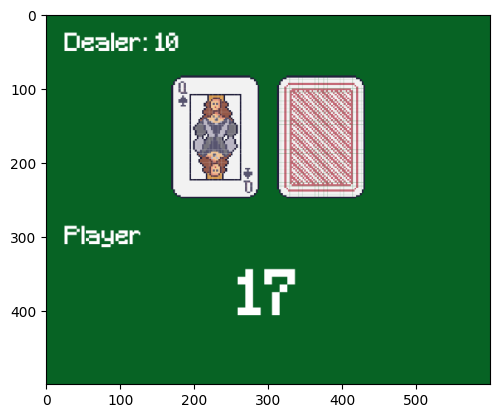

In [17]:
print("initial observation code:", env.reset())
action_space = env.action_space.n
print("action_space:", action_space)
plt.imshow(env.render())

In [18]:
n_training_episodes = 100_000
learning_rate = 0.01

n_eval_episodes = 10_000
env_id = "Blackjack-v1"
max_steps = 10
gamma = 0.95
eval_seed = []

max_epsilon = 1.0
min_epsilon = 0.01
decay_rate = 0.0001

In [19]:
def initialize_q_table_Blackj(action_space):
    Qtable = defaultdict(lambda: np.zeros(env.action_space.n))
    return Qtable

def greedy_policy_Blackj(Qtable, obs):
    return int(np.argmax(Qtable[obs]))

def epsilon_greedy_policy_Blackj(Qtable, state, epsilon):
    random_num = geterator.random()
    if random_num > epsilon:
        action = greedy_policy_Blackj(Qtable, state)
    else:
        action = env.action_space.sample()
    return action

In [20]:
Qtable_Blackj = initialize_q_table_Blackj(action_space)

In [21]:
def train_Blackj(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps, Qtable):
    if decay_rate is None:
        reduce_epsilon = LinearDecay(min_epsilon, max_epsilon, n_training_episodes)
    else:
        reduce_epsilon = ConstantDecay(min_epsilon, max_epsilon, decay_rate)

    for episode in tqdm(range(n_training_episodes)):
        epsilon = reduce_epsilon()
        state, info = env.reset()
        step = 0
        terminated = False
        truncated = False

        for step in range(max_steps):
            action = epsilon_greedy_policy_Blackj(Qtable, state, epsilon)
            new_state, reward, terminated, truncated, info = env.step(action)
            # print(reward)
            future_Q = (not terminated) * np.max(Qtable[new_state])
            temporal_difference = (
                reward + gamma * future_Q - Qtable[state][action]
            )

            Qtable[state][action] = (
                            Qtable[state][action] + learning_rate * temporal_difference
                        )
            if terminated or truncated:
                break

            state = new_state
    return Qtable

In [22]:
Qtable_Blackj = train_Blackj(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps, Qtable_Blackj)

  0%|          | 0/100000 [00:00<?, ?it/s]

In [23]:
def evaluate_agent_Blackj(env, max_steps, n_eval_episodes, Q, seed):
    episode_rewards = []
    wins = 0

    for episode in tqdm(range(n_eval_episodes)):
        if seed:
            state, info = env.reset(seed=seed[episode])
        else:
            state, info = env.reset()
        step = 0
        truncated = False
        terminated = False
        total_rewards_ep = 0
        for step in range(max_steps):
            action = epsilon_greedy_policy_Blackj(Q, state, 0)
            new_state, reward, terminated, truncated, info = env.step(action)
            total_rewards_ep += reward

            if terminated or truncated:
                break
            state = new_state
        episode_rewards.append(total_rewards_ep)
        if reward > 0:
            wins += 1
    mean_reward = np.mean(episode_rewards)
    std_reward = np.std(episode_rewards)
    mean_wind = wins / n_eval_episodes
    print(wins/n_eval_episodes)
    return mean_reward, std_reward, mean_wind

In [24]:
# Evaluate our Agent
mean_reward, std_reward, mean_wind = evaluate_agent_Blackj(env, max_steps, n_eval_episodes, Qtable_Blackj, eval_seed)
print(f"Mean_reward={mean_reward:.2f} +/- {std_reward:.2f}")
print(f"Mean wins={mean_wind} in {n_eval_episodes} games")

  0%|          | 0/10000 [00:00<?, ?it/s]

0.4204
Mean_reward=-0.07 +/- 0.95
Mean wins=0.4204 in 10000 games


###TLDR
42.22%
Classic or American Blackjack is the game you'll find in most casinos. You play this variation using a deck of 52 cards. Here, the blackjack win percentage or probability sits at 42.22%

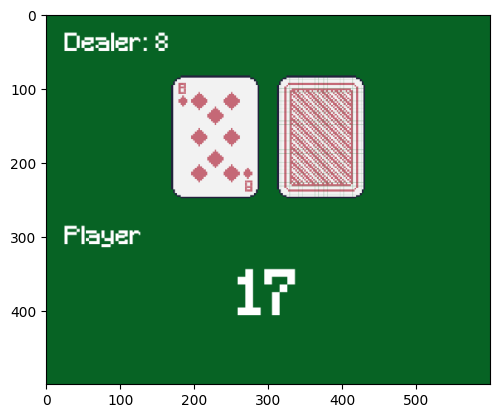

In [25]:
env.reset()
plt.imshow(env.render())

  0%|          | 0/5 [00:00<?, ?it/s]

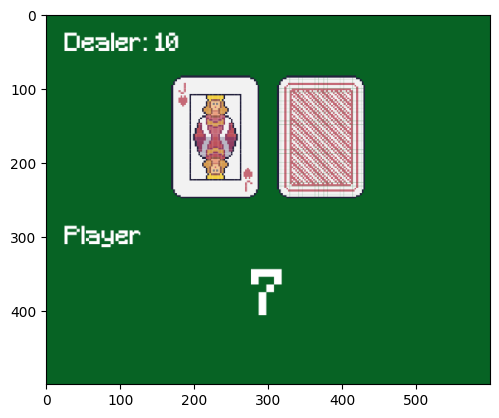

1 0.0 (18, 10, 1)


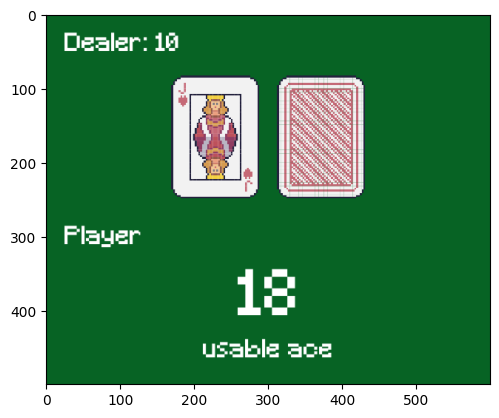

1 0.0 (18, 10, 0)


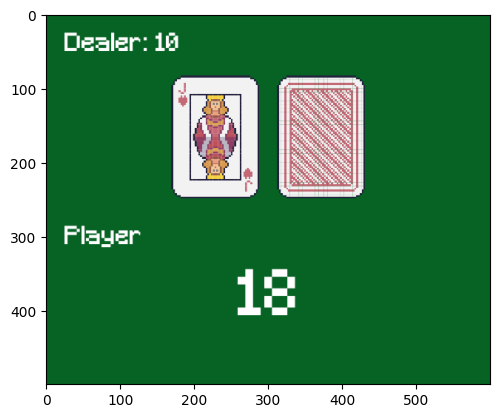

0 0.0 (18, 10, 0)


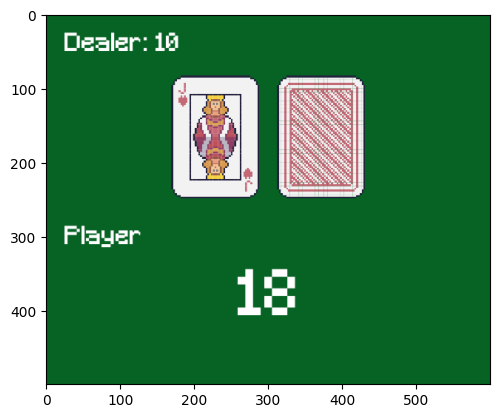

STOP








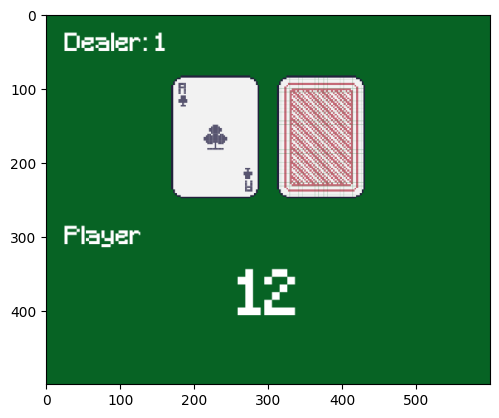

1 0.0 (18, 1, 0)


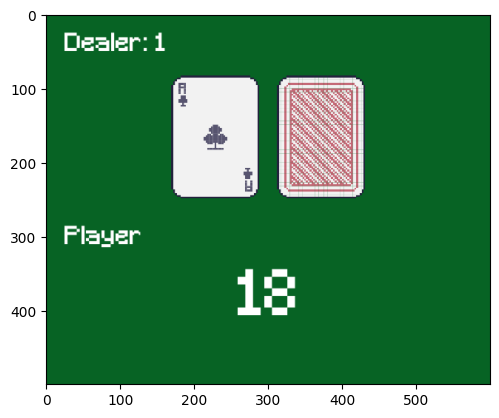

1 -1.0 (28, 1, 0)


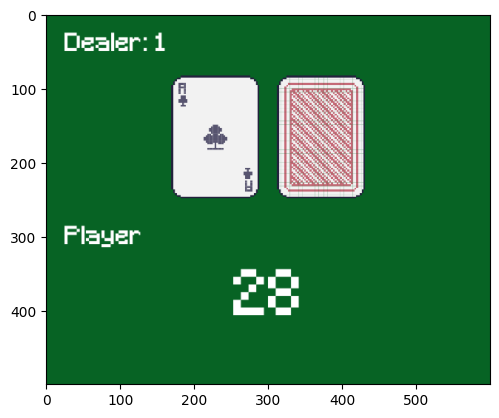

STOP








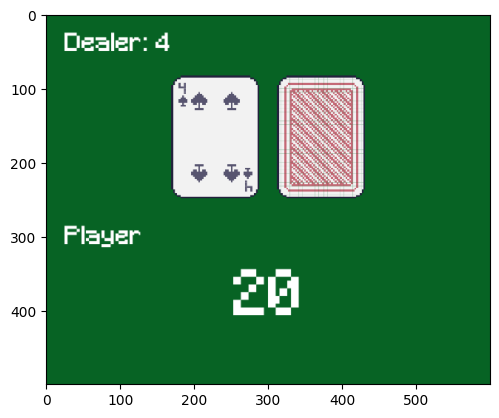

0 1.0 (20, 4, 0)


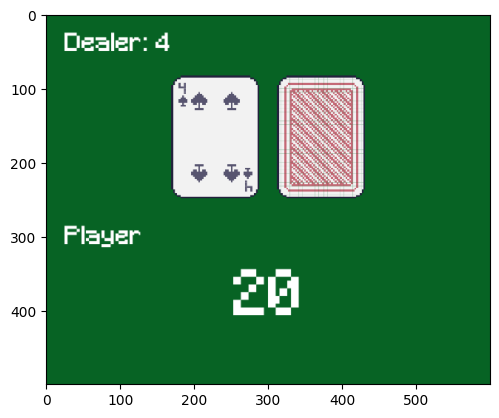

STOP








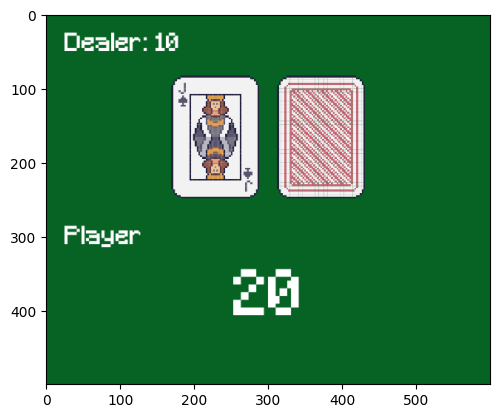

0 1.0 (20, 10, 0)


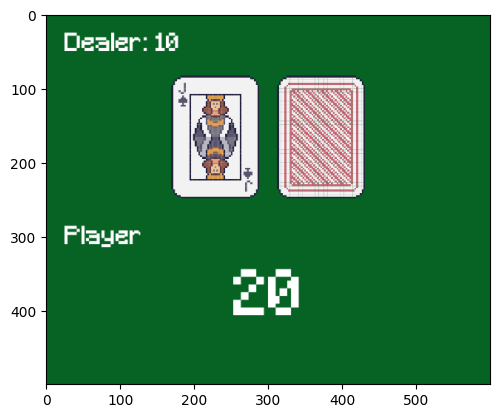

STOP








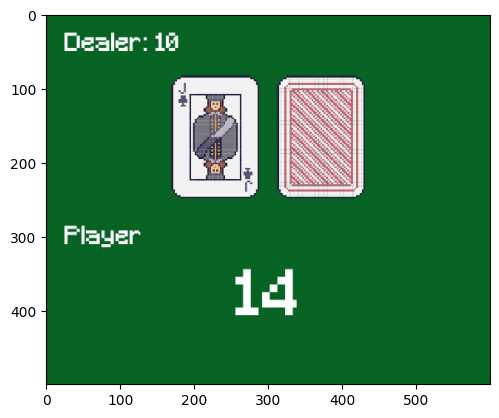

1 0.0 (19, 10, 0)


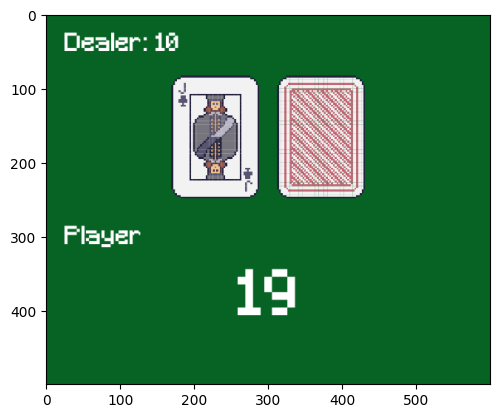

0 -1.0 (19, 10, 0)


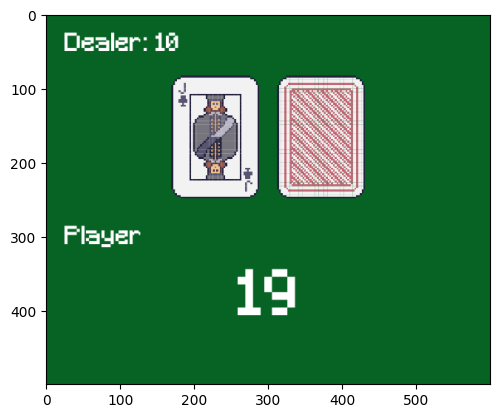

STOP






Wins 2


In [26]:
wins = 0
for episode in tqdm(range(5)):
    state, info = env.reset()
    done = False
    while not done:
        frame=env.render()
        plt.imshow(frame)
        plt.show()

        action =  epsilon_greedy_policy_Blackj(Qtable_Blackj, state, 0)
        next_obs, reward, terminated, truncated, info = env.step(action)
        print(action, reward, next_obs)
        done = terminated or truncated
        state = next_obs
    if reward > 0:
        wins += 1
    plt.imshow(env.render())
    plt.show()
    print("STOP\n\n\n\n\n\n")
print("Wins", wins)

# Task 2

In [27]:
env = gym.make("FrozenLake-v1", map_name="8x8", is_slippery=False, render_mode="rgb_array")

In [28]:
state_space = env.observation_space.n
action_space = env.action_space.n
print("state_space:", state_space)
print("action_space:", action_space)

state_space: 64
action_space: 4


In [29]:
def initialize_q_table(state_space, action_space):
  Qtable = np.zeros((state_space, action_space))
  return Qtable

def greedy_policy(Qtable, state):
  action = np.argmax(Qtable[state][:])
  return action

def epsilon_greedy_policy(Qtable, state, epsilon):
  random_num = geterator.random()
  if random_num > epsilon:
    action = greedy_policy(Qtable, state)
  else:
    action = env.action_space.sample()

  return action


def train_frozenlake(learning_rate, n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps, Qtable):
    if decay_rate is None:
        reduce_epsilon = LinearDecay(min_epsilon, max_epsilon, int(n_training_episodes * 0.9))
    else:
        reduce_epsilon = ConstantDecay(min_epsilon, max_epsilon, decay_rate)

    for episode in tqdm(range(n_training_episodes)):
        epsilon = reduce_epsilon()
        if abs(epsilon) < 0.000001:
            learning_rate = 0.0001
        state, info = env.reset()
        step = 0
        terminated = False
        truncated = False

        while not terminated and not truncated:
            action = epsilon_greedy_policy(Qtable, state, epsilon)

            new_state, reward, terminated, truncated, info = env.step(action)

            Qtable[state][action] = Qtable[state][action] + learning_rate * (reward + gamma * np.max(Qtable[new_state]) - Qtable[state][action])

            if truncated:
                Qtable[state][action] = Qtable[state][action] + learning_rate * (-0.01 + gamma * np.max(Qtable[new_state]) - Qtable[state][action])
                break

            state = new_state
    return Qtable

In [30]:
Qtable_frozenlake = initialize_q_table(state_space, action_space)

In [31]:
n_training_episodes = 15_000
learning_rate = 0.999
n_eval_episodes = 10000
max_steps = 200
gamma = 0.999
eval_seed = []
max_epsilon = 1.0
min_epsilon = 0.05
decay_rate = None

In [32]:
Qtable_frozenlake = train_frozenlake(learning_rate, n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps, Qtable_frozenlake)

  0%|          | 0/15000 [00:00<?, ?it/s]

In [33]:
# Qtable_frozenlake

In [34]:
# polici

In [35]:
# polici

line: 0: down down down down down down down down 
line: 1: down down down right down down down down 
line: 2: down down down left down right down down 
line: 3: right right right right down left down down 
line: 4: right right up left right right right down 
line: 5: up left left right right up left down 
line: 6: up left left up left up left down 
line: 7: up left left left left up left left 


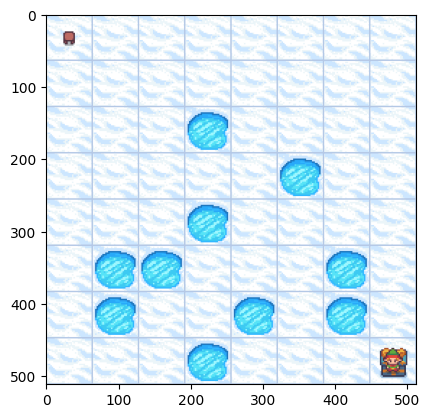

In [36]:
polici = [greedy_policy(Qtable_frozenlake, i) for i in range(len(Qtable_frozenlake))]
num_element_in_row = int(state_space ** 0.5)
for line_id, row in enumerate(range(0,len(polici), num_element_in_row)):
    print(f"line: {line_id}: ", end ="")
    for action in polici[row:row+num_element_in_row]:
        print(i2action[action], end=" ")
    print()
plt.imshow(env.render())

In [499]:
def evaluate_agent(env, max_steps, n_eval_episodes, Q, seed):
  episode_rewards = []
  for episode in tqdm(range(n_eval_episodes)):
    if seed:
      state, info = env.reset(seed=seed[episode])
    else:
      state, info = env.reset()
    step = 0

    truncated = False
    terminated = False
    total_rewards_ep = 0

    for step in range(max_steps):
      action = greedy_policy(Q, state)
      new_state, reward, terminated, truncated, info = env.step(action)
      total_rewards_ep += reward

      if terminated or truncated:
        break
      state = new_state
    episode_rewards.append(total_rewards_ep)
  mean_reward = np.mean(episode_rewards)
  std_reward = np.std(episode_rewards)

  return mean_reward, std_reward

mean_reward, std_reward = evaluate_agent(env, max_steps, n_eval_episodes, Qtable_frozenlake, eval_seed)
print(f"Mean_reward={mean_reward:.2f} +/- {std_reward:.2f}")

  0%|          | 0/10000 [00:00<?, ?it/s]

Mean_reward=1.00 +/- 0.00


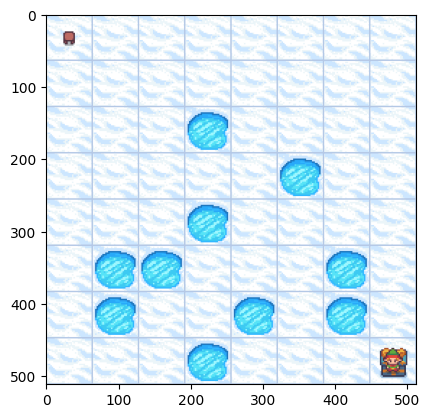

In [37]:
def show_run(Qtable):
    state, info = env.reset()
    for step in range(100):
        action = greedy_policy(Qtable, state)
        new_state, reward, terminated, truncated, info = env.step(action)
        if terminated or truncated:
            break
        state = new_state
    plt.imshow(env.render())
    plt.show()

show_run(Qtable_frozenlake)

Обойти проблему отсутствия положительных наград в случайных эпизодах игры помогло:
1. Добавление отрицательный награды за долгую игру.

2. Увеличение exploration rate и learning_rate